In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px

import os

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Used for exporting pandas tables "pip install dataframe-image"
# import dataframe_image as dfi

import datetime
from pyspark.sql.functions import col, from_unixtime, date_trunc, udf, lit
import pyspark.pandas as ps
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, count, from_unixtime, date_format
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
try:
    spark.stop()
except NameError:
    pass

### Helper Functions

Reusable Functions 

In [3]:
def save_df_image(df):
    """
    Save DataFrame as an image with a colored table.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be saved as an image.

    Returns:
    None
    """

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Hide the axes
    ax.axis("off")

    # Plot the DataFrame as a table with alternating column colors
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc="center",
        cellLoc="center",
        colColours=["#6EC33C", "#913CC3"] * len(df.columns),
    )

    # Adjust font size
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Save the figure as an image (e.g., PNG)
    plt.savefig("table_image.png", bbox_inches="tight", pad_inches=0.5)


def style_df(df):
    # Set Colors
    styles = [
        {
            "selector": "th.col_heading",
            "props": [("background-color", "#14345a"), ("color", "white")],
        },
        {
            "selector": "th.blank",
            "props": [("background-color", "#14345a"), ("color", "white")],
        },
        {
            "selector": "tr:nth-child(even)",
            "props": [("background-color", "#002351"), ("color", "white")],
        },
        {
            "selector": "tr:nth-child(odd)",
            "props": [("background-color", "#062c54"), ("color", "white")],
        },
    ]

    # Apply the styles to the DataFrame
    styled_df = df.style.set_table_styles(styles)

    return styled_df


def flag_rows(df, column_name, check_list, flagged_column_name):
    """
    Flag rows in a PySpark DataFrame based on whether the value in a specified column is in a given list.

    Parameters:
    - df (pyspark.sql.DataFrame): The PySpark DataFrame to be modified.
    - column_name (str): The name of the column to check for values.
    - check_list (list): The list of values to check against.
    - flagged_column_name (str): The name of the new column to be created for the flags.

    Returns:
    pyspark.sql.DataFrame: The modified PySpark DataFrame with the new flagged column.

    This function takes a PySpark DataFrame, a column name, a list of values, and a flagged column name. It then adds a new column to the DataFrame
    that contains a flag (1 or 0) based on whether the values in the specified column are present in the given list.
    """

    def check_list_udf(value):
        return 1 if value in check_list else 0

    check_list_udf = udf(check_list_udf, IntegerType())

    df = df.withColumn(flagged_column_name, check_list_udf(df[column_name]))

    return df

In [4]:
total_physical_cores = 16
available_cores_for_spark = total_physical_cores - 2
# Create a Spark session with an appropriate app name and executor cores
spark = (
    SparkSession.builder.appName("Sparkify")
    .config("spark.driver.memory", "12g")
    .config("spark.executor.memory", "12g")
    .config("spark.executor.cores", available_cores_for_spark)
    .getOrCreate()
)

24/01/16 02:18:56 WARN Utils: Your hostname, Jacobs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.4.156 instead (on interface en0)
24/01/16 02:18:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/16 02:18:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# userId is a string and NULL values shows as empty strings not NULL


psdf = spark.read.json(
    "/Users/jacobfletcher/git/churn_project/data/mini_sparkify_event_data.json"
)
psdf = psdf.withColumn("userId", col("userId").cast("int"))
psdf.printSchema()

# Build Temp Table for Future sql queries
psdf.createOrReplaceTempView("user_log")

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)



In [6]:
psdf.toPandas().to_csv("/Users/jacobfletcher/git/churn_project/data/mini_sparkify")

In [7]:
psdf.count()

286500

In [8]:
# Seperate column types
num_cols = [
    psdf.dtypes[i][0] for i in range(len(psdf.columns)) if psdf.dtypes[i][1] != "string"
]

obj_cols = [
    psdf.dtypes[i][0] for i in range(len(psdf.columns)) if psdf.dtypes[i][1] == "string"
]

## Explroing Null Values

In [9]:
def unique_nulls_count(df):
    if isinstance(df, DataFrame):
        summary_counts = [
            {
                "Column": c,
                "UniqueCount": df[[c]].distinct().count(),
                "NullCount": df[[c]].filter(col(c).isNull()).count(),
                "Type": df[[c]].dtypes[0][1],
            }
            for c in df.columns
        ]
    if isinstance(df, pd.DataFrame):
        summary_counts = [
            {
                "Column": c,
                "UniqueCount": df[c].nunique(),
                "NullCount": df[c].isnull().sum(),
                "Type": df[c].dtype,
            }
            for c in df.columns
        ]

    # Create a Pandas DataFrame
    return pd.DataFrame(summary_counts).sort_values("UniqueCount")


# columns_with_nulls = [summary_counts_df.iloc[i][0] for i in range(summary_counts_df.shape[0]) if summary_counts_df.iloc[i][2] > 0]
summary_counts_df = unique_nulls_count(psdf.toPandas())
# style_df(summary_counts_df.iloc[:9]).export_png("summary_counts(part1).png")
# style_df(summary_counts_df.iloc[9:]).export_png("summary_counts(part2).png")
style_df(summary_counts_df)

,Column,UniqueCount,NullCount,Type
3,gender,2,8346,object
7,level,2,0,object
9,method,2,0,object
14,status,3,0,int64
1,auth,4,0,object
10,page,22,0,object
16,userAgent,56,8346,object
8,location,114,8346,object
5,lastName,173,8346,object
2,firstName,189,8346,object


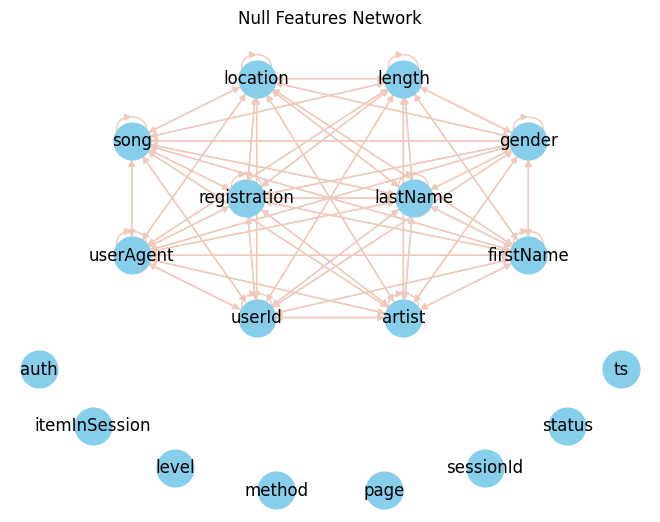

In [10]:
def null_combination_check(df):
    """
    Identify columns with null values and their related columns in a DataFrame.

    Parameters:
    - df (pyspark.sql.DataFrame or pd.DataFrame): The input DataFrame.

    Returns:
    dict: A dictionary where keys are columns with null values, and values are lists of related columns.
    """
    if isinstance(df, DataFrame):
        df = df.toPandas()

    null_relations = {}
    for column in df.columns:
        rows_with_nulls = df[df[column].isnull()]
        related_columns = rows_with_nulls.columns[
            rows_with_nulls.isnull().any()
        ].tolist()

        null_relations[column] = related_columns

    return null_relations


def null_graph(relationships, ignore_no_relations=False):
    """
    Visualize relationships between entities as a directed graph using NetworkX and Matplotlib.

    Parameters:
    - relationships (dict): A dictionary representing relationships between entities. Each key is an entity,
      and the corresponding value is a list of related entities.
    - ignore_no_relations (bool): If True, only entities with at least one relation will be included in the graph.
      If False (default), all entities and their relations will be considered.

    Returns:
    None

    This function takes a dictionary of relationships and creates a directed graph using NetworkX.
    Nodes in the graph represent entities, and directed edges represent relationships between entities.
    The graph is visualized using Matplotlib.
    """

    G = nx.DiGraph()

    # Add nodes and edges based on relationships
    for entity, related_entities in relationships.items():
        if ignore_no_relations and len(related_entities) == 0:
            # passes empty entities in loop
            continue

        G.add_node(entity)
        for related_entity in related_entities:
            G.add_edge(entity, related_entity)

    # Visualization
    pos = nx.kamada_kawai_layout(G)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=700,
        node_color="skyblue",
        font_size=12,
        font_color="black",
        arrowsize=10,
        edge_color="#EEC9BC",
    )
    plt.title("Null Features Network")
    plt.show()


null_graph(null_combination_check(psdf), ignore_no_relations=False)

/var/folders/zp/9kxj13m57_v23k2hkwd8vz600000gn/T/ipykernel_17882/1063085435.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


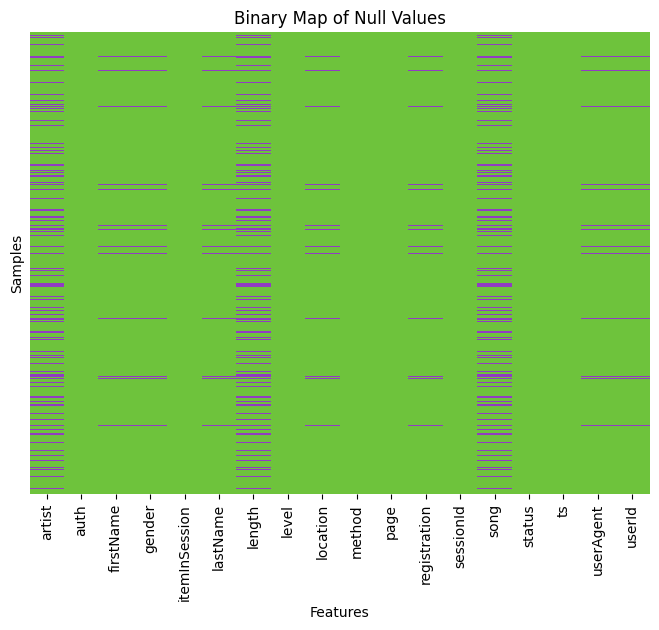

In [11]:
def binary_null_map(df):
    """
    Visualize the binary map of null values in a DataFrame using a heatmap.

    Parameters:
    - df (pyspark.sql.DataFrame or pd.DataFrame): The input DataFrame.

    Returns:
    None
    """

    if isinstance(df, DataFrame):
        df = df.toPandas()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        df.isnull(),
        cbar=False,
        yticklabels=False,
        cmap=["#6EC33C", "#913CC3"],
        ax=ax,
    )

    ax.set_xlabel("Features")
    ax.set_ylabel("Samples")
    ax.set_title("Binary Map of Null Values")

    fig.show()


binary_null_map(psdf)

# Exploring Features

## Flag Cancelled Users

In [12]:
cancelled_user_list = (
    psdf[["userId"]]
    .filter(col("page").isin(["Cancellation Confirmation"]))
    .distinct()
    .toPandas()
    .userId.tolist()
)
# cancelled_user_list = psdf.rdd.map(lambda x: x.userId).collect()

psdf = flag_rows(psdf, "userId", cancelled_user_list, "cancel_flag")


# Check that the amount of 'Cancel COnfirmations' are equal to that of the amount of unique userIds that were flagged
assert (
    psdf[["page"]].filter(col("page") == "Cancellation Confirmation").count()
    == psdf.filter(col("cancel_flag") == 1).groupBy("userId").count().count()
)

churn_user_count = (
    psdf.filter(col("cancel_flag") == 1).groupBy("userId").count().count()
)
unique_user_count = psdf.select("userId").distinct().count()

print(f"{round(churn_user_count /unique_user_count,4)*100}% Users Churned")

23.01% Users Churned


## Churn By Gender

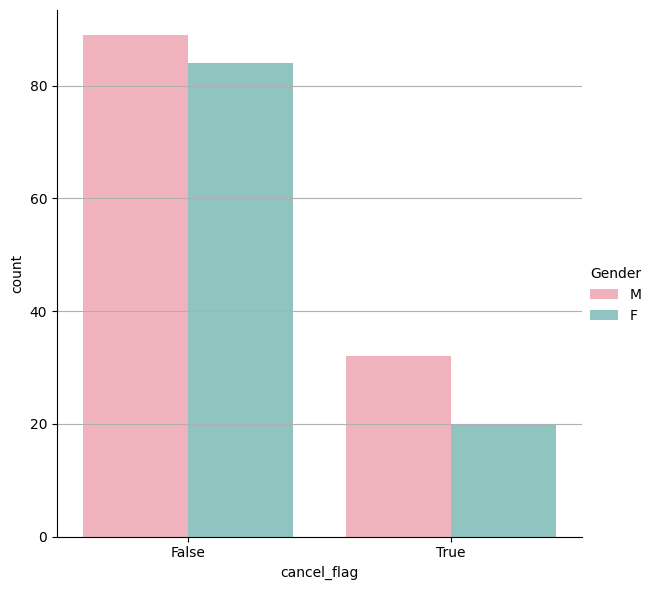

  Gender  cancel_flag  count
0      M        False     89
1      F        False     84
2      M         True     32
3      F         True     20


In [13]:
churn_by_gender = (
    psdf.dropDuplicates(["userId"]).select("Gender", "cancel_flag").toPandas().dropna()
)
churn_by_gender = churn_by_gender.value_counts().reset_index()
churn_by_gender["cancel_flag"] = churn_by_gender["cancel_flag"].astype(bool)


chart = sns.catplot(
    kind="bar",
    data=churn_by_gender,
    x="cancel_flag",
    y="count",
    hue="Gender",
    errorbar="sd",
    palette="husl",
    alpha=0.6,
    height=6,
)

chart.despine(left=False)
plt.grid(axis="y")
plt.show()


print(churn_by_gender)

## Churn By Location

In [14]:
user_by_state = (
    psdf.dropDuplicates(["userId"])
    .select(["location", "cancel_flag"])
    .toPandas()
    .dropna()
)
user_by_state["state"] = user_by_state["location"].str[-2:]
user_by_state.drop(columns="location", inplace=True)
user_by_state = user_by_state.value_counts().reset_index()


user_by_state[["state", "count"]].sort_values(by="count", ascending=False).head()


def state_heat(df, state_col="state", value_col="count", title=None):
    # Two Column DataFRam 1 column with states, the next stae value

    states = df[state_col].tolist()
    user_counts = df[value_col].to_list()

    fig = px.choropleth(
        locations=states,
        locationmode="USA-states",
        color=user_counts,
        scope="usa",
        title=title,
    )

    fig.show()


cancel_filter = user_by_state["cancel_flag"] == 1
noncancel_filter = user_by_state["cancel_flag"] == 0

In [15]:
state_heat(user_by_state, title="Users By State")

In [16]:
state_heat(user_by_state[cancel_filter], title="Cancelled Users By State")

In [17]:
state_heat(user_by_state[noncancel_filter], title="Non-Cancelled Users by State")

user_by_state

In [18]:
# Calculate Churn Pecentage By State
def churn_by_state(df):
    grouped_df = df.groupby("state")["count"].agg(
        total_count="sum",
        cancellation_count=lambda x: (x * df.loc[x.index, "cancel_flag"]).sum(),
    )
    grouped_df["churn_percentage"] = (
        grouped_df["cancellation_count"] / grouped_df["cancellation_count"].sum()
    ) * 100
    return grouped_df


churn_by_state_df = churn_by_state(user_by_state)

churn_by_state_df.sort_values("churn_percentage", ascending=False).describe()

,total_count,cancellation_count,churn_percentage
count,39.000000,39.000000,39.000000
mean,5.769231,1.333333,2.564103
std,6.076103,1.401753,2.695679
min,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,4.000000,1.000000,1.923077
75%,7.000000,2.000000,3.846154
max,33.000000,6.000000,11.538462


In [19]:
state_heat(
    churn_by_state_df.reset_index(),
    value_col="churn_percentage",
    title="Churn Percentage By State",
)

In [20]:
assert (
    user_by_state[["state", "count"]].groupby("state").sum()["count"].tolist()
    == churn_by_state(user_by_state)["total_count"].tolist()
)

## Churn By Browser

In [27]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType


def ua_check(sdf):
    from ua_parser import user_agent_parser

    def device_check(ua):
        if ua:
            ua = ua.replace("\\", "")
            parsed_string = user_agent_parser.Parse(ua)
            return parsed_string["os"]["family"]
        else:
            return "Other"

    def browser_check(ua):
        if ua:
            ua = ua.replace("\\", "")
            parsed_string = user_agent_parser.Parse(ua)
            return parsed_string["user_agent"]["family"]
        else:
            return "Other"

    device_check_udf = udf(device_check, StringType())
    browse_brand_udf = udf(browser_check, StringType())

    sdf = sdf.withColumn("device", device_check_udf (sdf["userAgent"]))
    sdf = sdf.withColumn("browser", browse_brand_udf(sdf["userAgent"]))

    return sdf


psdf = ua_check(psdf)

psdf[["browser", "device"]].distinct().show()

+-------------+--------+
|      browser|  device|
+-------------+--------+
|Mobile Safari|     iOS|
|       Chrome|Mac OS X|
|       Chrome|   Linux|
|      Firefox|   Linux|
|           IE| Windows|
|       Chrome| Windows|
|      Firefox|Mac OS X|
|       Safari|Mac OS X|
|        Other|   Other|
|      Firefox| Windows|
|      Firefox|  Ubuntu|
+-------------+--------+



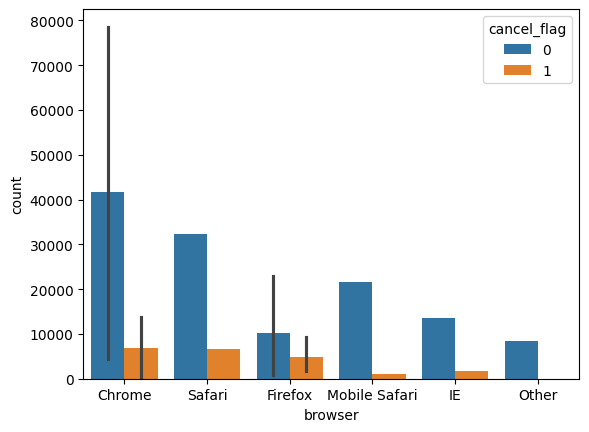

In [49]:
browser_device_cancel = psdf[["browser", "device", "cancel_flag"]].toPandas()


browser_device_cancel = browser_device_cancel.value_counts().reset_index()


sns.barplot(data=browser_device_cancel, x="browser", y="count", hue="cancel_flag")
plt.show()

<Axes: xlabel='device', ylabel='count'>

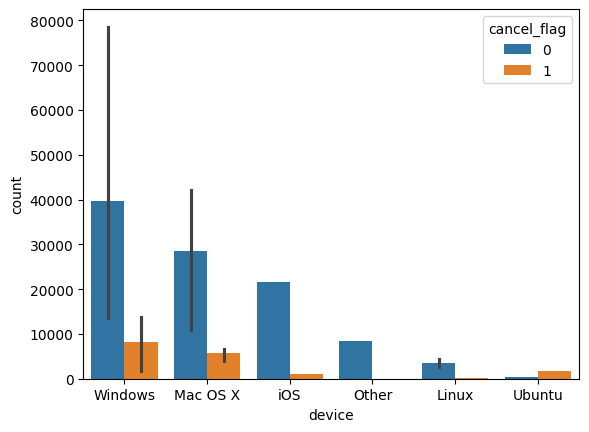

In [50]:
sns.barplot(data=browser_device_cancel, x='device', y='count', hue='cancel_flag')

## Pages

In [ ]:
cancel_pages_df = (
    psdf.filter(col("cancel_flag") == 1)
    .groupBy("page")
    .count()
    .orderBy(col("count").desc())
    .toPandas()
)

non_cancel_pages_df = (
    psdf.filter(col("cancel_flag") == 0)
    .groupBy("page")
    .count()
    .orderBy(col("count").desc())
    .toPandas()
)


pages_df = pd.merge(cancel_pages_df, non_cancel_pages_df, on="page")

pages_df.rename(
    columns={"count_x": "cancelled", "count_y": "not_cancelled"}, inplace=True
)


pages_df["total"] = pages_df["cancelled"] + pages_df["not_cancelled"]
pages_df["percentage_from_cancelled"] = pages_df["cancelled"] / pages_df["total"]

pages_df

In [ ]:
sum_user_page_counts = (
    psdf.dropna(subset="userId")
    .select(["page", "cancel_flag", "userId", "level"])
    .toPandas()
)

sum_user_page_counts_df = (
    sum_user_page_counts.groupby(["cancel_flag", "userId", "level"])
    .agg(sum_page_visits=("page", "count"))
    .reset_index()
)

avg_user_page_counts = (
    sum_user_page_counts_df.groupby(["cancel_flag", "level"])
    .agg(mean_page_visits=("sum_page_visits", "mean"))
    .reset_index()
)

avg_user_page_counts
chart = sns.catplot(
    kind="bar",
    data=avg_user_page_counts,
    x="level",
    y="mean_page_visits",
    hue="cancel_flag",
    errorbar="sd",
    palette="husl",
    alpha=0.6,
    height=6,
)

chart.despine(left=False)
plt.grid(axis="y")
plt.title("Total Page Visits by Cancelled User ")
plt.show()

In [ ]:
sum_user_page_counts = (
    psdf.dropna(subset="userId")
    .filter(col("page") == "NextSong")
    .select(["page", "cancel_flag", "userId", "level"])
    .toPandas()
)

sum_user_page_counts_df = (
    sum_user_page_counts.groupby(["cancel_flag", "userId", "level"])
    .agg(sum_page_visits=("page", "count"))
    .reset_index()
)

avg_user_page_counts = (
    sum_user_page_counts_df.groupby(["cancel_flag", "level"])
    .agg(mean_page_visits=("sum_page_visits", "mean"))
    .reset_index()
)

avg_user_page_counts
chart = sns.catplot(
    kind="bar",
    data=avg_user_page_counts,
    x="level",
    y="mean_page_visits",
    hue="cancel_flag",
    errorbar="sd",
    palette="husl",
    alpha=0.6,
    height=6,
)

chart.despine(left=False)
plt.grid(axis="y")
plt.title("Total Page Visits by Cancelled User ")
plt.show()

In [ ]:
thumbs = ["Thumbs Up", "Thumbs Down"]
sum_user_thumbs = (
    psdf.dropna(subset="userId")
    .filter(col("page").isin(thumbs))
    .select(["page", "cancel_flag", "userId", "level"])
    .toPandas()
)

sum_user_thumbs_counts = (
    sum_user_thumbs.groupby(["cancel_flag", "userId", "level"])
    .agg(sum_thumbs_interactions=("page", "count"))
    .reset_index()
)

avg_user_thumbs_counts = (
    sum_user_thumbs_counts.groupby(["cancel_flag", "level"])
    .agg(mean_thumbs_interactions=("sum_thumbs_interactions", "mean"))
    .reset_index()
)

chart = sns.catplot(
    kind="bar",
    data=avg_user_thumbs_counts,
    x="level",
    y="mean_thumbs_interactions",
    hue="cancel_flag",
    errorbar="sd",
    palette="husl",
    alpha=0.6,
    height=6,
)

chart.despine(left=False)
plt.grid(axis="y")
plt.title("Total Page Visits by Cancelled User ")
plt.show()

In [ ]:
round(avg_user_thumbs_counts)

### Unique Counts of Upgrades/Downgrades


In [ ]:
service_change = [
    "Downgrade",
    "Upgrade",
    "Submit Upgrade",
    "Submit Downgrade",
    "Cancel",
    "Cancellation Confirmation",
]


service_change_df = style_df(
    psdf[["page", "cancel_flag"]]
    .filter(col("page").isin(service_change))
    .groupBy("page")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)

# service_change_df.export_png("service_change.png")-
service_change_df

In [ ]:
service_change = [
    "Downgrade",
    "Submit Downgrade",
    "Cancel",
    "Cancellation Confirmation",
]


service_change_df = (
    psdf[["page", "userId", "cancel_flag"]]
    .filter(col("page").isin(service_change))
    .toPandas()
)

service_change_df = service_change_df.groupby("userId").value_counts().reset_index()

service_change_df = service_change_df.pivot(
    index="userId", columns="page", values="count"
).fillna(value=0)


# service_change_df[service_change_df['Cancellation Confirmation'] > 0].sum()

print(service_change_df)

In [ ]:
service_change_df[service_change_df["Submit Downgrade"] == 1].sort_values(
    "Downgrade", ascending=False
)

In [ ]:
service_change_df

In [ ]:
service_change = [
    "Downgrade",
    "Submit Downgrade",
    "Cancel",
    "Cancellation Confirmation",
]

service_change_df = psdf.select("page").distinct().toPandas()
service_change_s = service_change_df.squeeze().tolist()

service_change_df = (
    psdf[["page", "userId"]].filter((col("page").isin(service_change))).toPandas()
)


service_change_df = service_change_df.groupby("userId").value_counts().reset_index()

service_change_df = service_change_df.pivot(
    index="userId", columns="page", values="count"
).fillna(value=0)

service_funnel = service_change_df.sum().sort_values(ascending=False)
data = dict(stages=service_funnel.keys(), numbers=service_funnel.values)
fig = px.funnel(data, x="numbers", y="stages")
fig.show()

service_change_df

In [ ]:
# Heatmap to show correlation between pages
plt.figure(figsize=(8, 6))
sns.heatmap(
    service_change_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)
plt.title("Downgrade/Cancel Page Correalations")
plt.show()

In [ ]:
temp_df = psdf[["artist"]].toPandas().dropna().value_counts().reset_index()


temp_df = temp_df.rename(columns={"count": "song_plays"})


temp_df = temp_df["song_plays"].value_counts().reset_index()
temp_df = temp_df[temp_df["count"] > 10]

temp_df

## Song Plays Per

In [ ]:
def get_hour(value):
    return int(datetime.datetime.fromtimestamp(value / 1000.0).hour)


def get_day_of_week(value):
    return datetime.datetime.fromtimestamp(value / 1000.0).strftime("%A")


get_hour_udf = udf(get_hour, IntegerType())
get_day_of_week_udf = udf(get_day_of_week, StringType())

psdf = psdf.withColumn("hour_of_day", get_hour_udf("ts"))
psdf = psdf.withColumn("day_of_week", get_day_of_week_udf("ts"))

In [ ]:
times_df = (
    psdf.dropna(subset="userId")
    .filter(col("page") == "NextSong")
    .select(["hour_of_day", "day_of_week", "userId", "cancel_flag"])
    .toPandas()
)

In [ ]:
sum_day_counts_df = (
    times_df.groupby(["cancel_flag", "userId", "day_of_week"])
    .agg(sum_page_visits=("day_of_week", "count"))
    .reset_index()
)


avg_user_day_song_counts = (
    sum_day_counts_df.groupby(["cancel_flag", "day_of_week"])
    .agg(mean_song_listens=("sum_page_visits", "mean"))
    .reset_index()
)

weekday_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
pd.Categorical(
    avg_user_day_song_counts["day_of_week"], categories=weekday_order, ordered=True
)


sns.barplot(
    data=avg_user_day_song_counts,
    y="mean_song_listens",
    x="day_of_week",
    hue="cancel_flag",
)
plt.show()

In [ ]:
avg_user_day_song_counts

In [ ]:
times_df.groupby(["cancel_flag", "userId", "hour_of_day"]).agg(
    sum_hourly_plays=("hour_of_day", "count")
).reset_index()

In [ ]:
(
    times_df.groupby(["cancel_flag", "userId", "hour_of_day"])
    .agg(sum_hourly_plays=("hour_of_day", "count"))
    .reset_index()
)

In [ ]:
sum_user_hourly_listens = (
    times_df.groupby(["cancel_flag", "userId", "hour_of_day"])
    .agg(sum_hourly_listens=("hour_of_day", "count"))
    .reset_index()
)


avg_user_hourly_listens = (
    sum_user_hourly_listens.groupby(["cancel_flag", "hour_of_day"])
    .agg(mean_hourly_listens=("sum_hourly_listens", "mean"))
    .reset_index()
)


sns.barplot(
    data=avg_user_hourly_listens,
    y="mean_hourly_listens",
    x="hour_of_day",
    hue="cancel_flag",
)

In [ ]:
song_listens = (
    psdf.dropna(subset="artist")
    .filter(col("page") == "NextSong")
    .select(["hour_of_day", "day_of_week", "cancel_flag"])
    .toPandas()
    .value_counts()
    .reset_index()
)

avg_user_hourly_listens_by_day = (
    song_listens.groupby(["day_of_week", "hour_of_day"])
    .agg(mean_hourly_listens=("count", "mean"))
    .reset_index()
)


sns.relplot(
    data=song_listens,
    y="count",
    x="hour_of_day",
    hue="day_of_week",
    kind="scatter",
    style="cancel_flag",  # You can explore other kinds like 'line' or 'lineplot'
)

In [ ]:
songs_listened = psdf.filter(col("artist").isNotNull()).groupBy(col("userId")).count()

songs_listened.show()

## Page Interactions


In [ ]:
page_interactions = ["Thumbs Up", "Add to Playlist", "Thumbs Down", "Add Friend"]

psdf[["userId"]].filter(
    col("page").isin(page_interactions) & ~col("userID").isNull()
).toPandas().value_counts().reset_index()

In [ ]:
asddadas

In [ ]:
asddadas

In [ ]:
page_issues = ["Help", "Error"]

psdf[["userId"]].filter(
    col("page").isin(page_issues) & ~col("userID").isNull()
).toPandas().value_counts().reset_index()

# Feature Engineering

### Approach
<b>Features To Build </b>
- Total Songs Listened To
- App Page Interactions
    - Thumbs Up
    - Thumbs Down
    - Add Friend
    - Add to playlist
- Help Page Interactions/Error Page Interactions


<b> Key Points </b>
- The Feature dataframe will be created based on the userId
- Transformations will need to maximize Pyspark capabilities

In [ ]:
clean_psdf.columns

In [ ]:
clean_psdf = psdf.dropna(subset="userId")
clean_psdf.createOrReplaceTempView("cleaned_user_log")
unique_users = clean_psdf[["userId"]].distinct()

clean_psdf = clean_psdf.withColumn("ts", (col("ts") / 1000).cast("timestamp"))

# Apply date_format function
clean_psdf = clean_psdf.withColumn("date", date_format(col("ts"), "yyyy-MM-dd"))

# clean_psdf = clean_psdf.withColumn("ts", from_unixtime(col("ts") / 1000))  # Assuming ts is in milliseconds
# clean_psdf = psdf.withColumn("date", date_format(col("ts"), "yyyy-MM-dd"))

In [ ]:
def handle_missing_users(
    sdf: DataFrame, unique_users: DataFrame, fill_value=lit(0)
) -> DataFrame:
    """
    Handle missing users in a PySpark DataFrame.

    Parameters:
    - sdf (DataFrame): PySpark DataFrame representing user data. Should have columns 'userId' and 'featur_name'.
    - unique_users (DataFrame): PySpark DataFrame with unique user information.

    Returns:
    - DataFrame: Updated PySpark DataFrame with filled missing users.
    """

    sdf_user_count = sdf.count()

    unique_count = unique_users.count()

    if sdf_user_count != unique_count:
        print(f"Missing Values: {unique_count - sdf_user_count}")
        missing_users = unique_users.select("userId").subtract(sdf.select("userId"))
        # Since the sdf is only two we rename the column based on sdf's second column
        missing_users_sdf = missing_users.withColumn(sdf.columns[1], fill_value)
        filled_missing_users = sdf.union(missing_users_sdf)

        return filled_missing_users
    else:
        return sdf

## Build Features

### Song Counts

In [ ]:
song_counts = (
    clean_psdf[["userId", "artist"]].dropna(subset="artist").groupBy("userId").count()
)
song_counts = song_counts.withColumnRenamed("count", "song_counts")

song_counts = handle_missing_users(song_counts, unique_users)

### Distinct Artist

In [ ]:
distinct_artist = (
    clean_psdf.filter(clean_psdf["artist"].isNotNull())
    .groupBy("userId")
    .agg(F.countDistinct("artist").alias("distinct_artist"))
)

distinct_artist = handle_missing_users(distinct_artist, unique_users)

### User Level

In [ ]:
user_level = (
    clean_psdf[["userId", "level", "ts"]]
    .orderBy("ts", ascending=False)
    .dropDuplicates(subset=["userId"])
    .select("userId", "level")
)

level_flag_udf = udf(lambda x: 1 if x == "paid" else 0, IntegerType())

# one-hot encode
user_level = user_level.withColumn(
    "level_flag", level_flag_udf(user_level["level"])
).select("userId", "level_flag")

user_level = handle_missing_users(user_level, unique_users)

### Positive App Usage

In [ ]:
positive_usage_list = ["Thumbs Up", "Thumbs Down", "Add Friend", "Add to playlist"]

positive_usage = (
    clean_psdf[["userId", "page"]]
    .filter(col("page").isin(positive_usage_list))
    .groupBy("userId")
    .count()
)

positive_usage = positive_usage.withColumnRenamed("count", "pos_interactions")

positive_usage = handle_missing_users(positive_usage, unique_users)

### Negative Interactions

In [ ]:
neg_interactions_list = ["Error", "Help"]

neg_interactions = (
    clean_psdf[["userId", "page"]]
    .filter(col("page").isin(neg_interactions_list))
    .groupBy("userId")
    .count()
)

neg_interactions = neg_interactions.withColumnRenamed("count", "neg_interactions")


neg_interactions = handle_missing_users(neg_interactions, unique_users)

### Unique Locations

In [ ]:
unique_locations = (
    clean_psdf.filter(clean_psdf["location"].isNotNull())
    .groupBy("userId")
    .agg(F.countDistinct("location").alias("unique_locations"))
)


unique_locations = handle_missing_users(unique_locations, unique_users)

### Avg Daily Listens

In [ ]:
# Calculate the average daily listens per user
average_daily_listens = (
    clean_psdf.dropna(subset="artist")
    .groupBy("userId", "date")
    .agg(count("artist").alias("daily_listens"))
)
average_daily_listens = average_daily_listens.groupBy("userId").agg(
    {"daily_listens": "avg"}
)

average_daily_listens = handle_missing_users(average_daily_listens, unique_users)

### Page Counts

In [ ]:
page_filter = ["Cancel", "Cancellation Confirmation", "NextSong"]
page_count_df = (
    clean_psdf[["userId", "page"]]
    .filter(~col("page").isin(page_filter))
    .toPandas()
    .groupby("userId")
    .value_counts()
    .reset_index()
    .pivot(columns="page", values="count", index="userId")
    .fillna(int(0))
)


page_count_corr = page_count_df.corr()

sns.heatmap(
    page_count_corr,
    annot=False,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
)

page_count = spark.createDataFrame(page_count_df.reset_index())

### Sessions

In [ ]:
from pyspark.sql.functions import countDistinct

clean_psdf.groupBy("userId").agg(
    countDistinct("sessionId").alias("sessionCount")
).show()

### Label

In [ ]:
clean_psdf[["userId", "page"]].filter(
    col("page").isin(["Cancellation Confirmation"])
).distinct().show()

In [ ]:
labels = (
    clean_psdf[["userId", "page"]]
    .filter(col("page").isin(["Cancellation Confirmation", "Cancel"]))
    .drop_duplicates(["userId"])
)


labels = labels.withColumn("label", lit(1))
labels_df = labels.drop("page")

labels_df = handle_missing_users(labels_df, unique_users)

In [ ]:
labels = (
    clean_psdf[["userId", "page"]]
    .filter(col("page").isin(["Cancellation Confirmation", "Cancel"]))
    .drop_duplicates(["userId"])
)


labels = labels.withColumn("label", lit(1))
labels_df = labels.drop("page")

labels_df = handle_missing_users(labels_df, unique_users)

labels_df.show()

In [ ]:
dfs = [
    # song_counts,
    # song_listened_mean,
    average_daily_listens,
    user_level,
    positive_usage,
    neg_interactions,
    unique_locations,
    distinct_artist,
    page_count,
]

joined_features = labels_df
for df in dfs:
    joined_features = joined_features.join(df, "userId", "outer")

### Export Features For Model Testing

In [ ]:
joined_features.dropDuplicates().drop("userId").toPandas().to_csv(
    "mini_selected_features.csv"
)

### Feature Correalations

In [ ]:
joined_features_df = joined_features.toPandas().drop(labels="userId", axis=1)
# joined_features_df = joined_features_df.drop(
#     labels=["song_counts", "unique_locations"], axis=1
# )

correlation_matrix = joined_features_df.corr()

joined_features_df
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Extracted Feature Correalations")
plt.show()

In [ ]:
from itertools import combinations

# Filter correlations greater than 0.8 (adjust the threshold as needed)
highly_correlated_pairs = []

# Iterate over all combinations of column pairs
for col1, col2 in combinations(correlation_matrix.columns, 2):
    if correlation_matrix[col1][col2] > 0.8:
        highly_correlated_pairs.append((col1, col2, correlation_matrix[col1][col2]))

# Print or use the filtered pairs
print("Highly Correlated Pairs:")


print(pd.DataFrame(data=highly_correlated_pairs).sort_values(by=0))

In [ ]:
pandas_df = joined_features.toPandas()

for column in pandas_df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=pandas_df[column])
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.show()

In [ ]:
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

df = joined_features_df.drop_duplicates().fillna(0).copy()

Y = df["label"]
X = df.iloc[:, 1:]

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA()
X = pca.fit_transform(X)
pca.get_covariance()
explained_variance = pca.explained_variance_ratio_

In [ ]:
with plt.style.context("dark_background"):
    plt.figure(figsize=(6, 4))
    plt.bar(
        range(len(explained_variance)),
        explained_variance,
        alpha=0.5,
        align="center",
        label="individual explained variance",
    )
    plt.xlabel("Principal components")
    plt.ylabel("Explained variance ratio")
    plt.legend()
    plt.tight_layout()

In [ ]:
with plt.style.context("dark_background"):
    plt.figure(figsize=(6, 4))
    plt.bar(
        range(6), explained_variance[:6], alpha=0.5, align="center"
    )  # , label='individual explained variance' )
    plt.xlabel("Principal components")
    plt.ylabel("Explained variance ratio")
    plt.legend()
    plt.tight_layout()

In [ ]:
clean_psdf[["location", "userId"]]

In [ ]:
ex = 12
str(ex) + "g"